In [16]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import pandas as pd
import numpy as np
import math

# Ensure all rows and columns are printed
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

### Relabeling of segmentation labels to hughlight common structures in mouse and human atalses

In [17]:
## load in the mouse and human atlases

human_labels = sitk.ReadImage("./data/human_labels_affine_aligned.nii") # start with unprocessed atlases
mouse_labels = sitk.ReadImage("./atlases/mouse_labelsReformat.nii")

human_labels_array = sitk.GetArrayFromImage(human_labels)
mouse_labels_array = sitk.GetArrayFromImage(mouse_labels)

print("human_labels_array dim:", human_labels_array.shape)
print("mouse_labels_array dim:", mouse_labels_array.shape)

human_labels_df = pd.read_csv("./atlases/human_CerebrA_LabelDetails.csv")
mouse_labels_df = pd.read_csv("./atlases/mouse_c57_brain_atlas_labels.csv")

# to aid with string matching convert all labels to lowercase
human_labels_df["Label Name"] = human_labels_df["Label Name"].astype(str).str.lower()

# Other overlapping labels include:

common_label_diff_names = { # "label_mouse": "label_human"
    "optic tract": "optic chiasm",
    "arbor vita of cerebellum": "cerebellum white matter",
    "nucleus accumbens": "accumbens area",
    "globus pallidus": "pallidum",
}


human_labels_array dim: (128, 153, 129)
mouse_labels_array dim: (548, 282, 420)


In [18]:
## relabel the regions with the same values in the mouse and human datasets

# Find common elements
common = list(set(human_labels_df["Label Name"]) & set(mouse_labels_df["Structure"]))

# Print results
print("Number of common labels:", len(common))
print("Common labels:", common)


# want to give these the same labels to display in seg masks!!
# just relabel them to be greater the max of both images
# and relabel the intensity in the image
max_int = int(np.maximum(np.max(human_labels_array), np.max(mouse_labels_array)))

# check that matches the max label in dfs
max_dfs = np.maximum(np.max(human_labels_df[["RH Label", "LH Labels"]]), np.max(mouse_labels_df[["right label", "left label"]]))

new_label_val = max_int + 1

## ISSUE: woith hjow the keys are being extracted
dict_keys = [i for i in common_label_diff_names.keys()]
common += dict_keys
print("Updated common labels:",common)


# now relabel starting at 251, 252 pair
for label in common:
    print("label:", label)
    if (label in common_label_diff_names):
        label_mouse = label
        label_human = common_label_diff_names[label]
    else:
        label_mouse = label
        label_human = label

    # change the intensities in the image
    # get current intesities to know what pxls to filter
    human_right_intensity = human_labels_df["RH Label"][human_labels_df["Label Name"] == label_human].values[0]
    human_left_intensity = human_labels_df["LH Labels"][human_labels_df["Label Name"] == label_human].values[0]

    mouse_right_intensity = mouse_labels_df["right label"][mouse_labels_df["Structure"] == label_mouse].values[0]
    mouse_left_intensity = mouse_labels_df["left label"][mouse_labels_df["Structure"] == label_mouse].values[0]

    # overwrite these intensity values with the new ones
    # overwritting values in a numpy array
    human_labels_array[human_labels_array == human_right_intensity] = new_label_val
    mouse_labels_array[mouse_labels_array == mouse_right_intensity] = new_label_val

    human_labels_array[human_labels_array == human_left_intensity] = new_label_val + 1
    mouse_labels_array[mouse_labels_array == mouse_left_intensity] = new_label_val + 1

    
    # relabel both df labels
    human_labels_df.loc[human_labels_df["Label Name"] == label_human, "RH Label"] = new_label_val
    mouse_labels_df.loc[mouse_labels_df["Structure"] == label_mouse, "right label"] = new_label_val
    new_label_val += 1

    human_labels_df.loc[human_labels_df["Label Name"] == label_human, "LH Labels"] = new_label_val
    mouse_labels_df.loc[mouse_labels_df["Structure"] == label_mouse, "left label"] = new_label_val

    new_label_val += 1



Number of common labels: 7
Common labels: ['hippocampus', 'third ventricle', 'fourth ventricle', 'basal forebrain', 'amygdala', 'thalamus', 'lateral ventricle']
Updated common labels: ['hippocampus', 'third ventricle', 'fourth ventricle', 'basal forebrain', 'amygdala', 'thalamus', 'lateral ventricle', 'optic tract', 'arbor vita of cerebellum', 'nucleus accumbens', 'globus pallidus']
label: hippocampus
label: third ventricle
label: fourth ventricle
label: basal forebrain
label: amygdala
label: thalamus
label: lateral ventricle
label: optic tract
label: arbor vita of cerebellum
label: nucleus accumbens
label: globus pallidus


In [19]:
## save the updated labeled atlases
mouse_labels_img = sitk.GetImageFromArray(mouse_labels_array)
human_labels_img = sitk.GetImageFromArray(human_labels_array)


# align atlases - rotate the mouse atlas to have the same axis as the human atlas
# currently the mouse z slice is thec coronal plane, want to be the transverse plane
mouse_labels_img_permute = sitk.PermuteAxes(mouse_labels_img, [0, 2, 1])

sitk.WriteImage(mouse_labels_img_permute, "./atlases/mouse_labels_common.nii")
sitk.WriteImage(human_labels_img, "./atlases/human_labels_common.nii")

mouse_labels_df.to_csv("./atlases/mouse_labels_common.csv", index=False)
human_labels_df.to_csv("./atlases/human_labels_common.csv", index=False)



### Image processing helper functions

In [37]:
def crop_brain(img, other_img=None):
    # find mix/max x,y,z that have a nonzero value
    # to comoute the bounding box of the labels
    img_arr = sitk.GetArrayFromImage(img)
    non_zero_indices = np.argwhere(img_arr != 0)

    min_coords = np.min(non_zero_indices, axis=0)
    max_coords = np.max(non_zero_indices, axis=0)
    
    # cast all to int
    start = [int(unsigned_int) for unsigned_int in min_coords]
    size = [int(unsigned_int) for unsigned_int in max_coords - min_coords]

    # swap axes since sitk uses (x,y,z) but numpy uses (z,x,y)
    start = start[::-1]
    size = size[::-1]

    # crop the image array to that bounding box
    cropped_img = sitk.RegionOfInterest(img, size=size, index=start)

    if other_img == None:
        return cropped_img
    else:
        cropped_other_img = sitk.RegionOfInterest(other_img, size=size, index=start)
    return cropped_img, cropped_other_img

def numpy_crop_brain(img, other_img=None):
    img_arr = sitk.GetArrayFromImage(img)
    non_zero_indices = np.argwhere(img_arr != 0)

    min_coords = np.min(non_zero_indices, axis=0)
    max_coords = np.max(non_zero_indices, axis=0)

    if other_img != None:
        other_img_arr = sitk.GetArrayFromImage(other_img)
        other_non_zero_indices = np.argwhere(other_img_arr != 0)

        other_min_coords = np.min(other_non_zero_indices, axis=0)
        other_max_coords = np.max(other_non_zero_indices, axis=0)

        # elementwise
        min_coords = np.minimum(min_coords, other_min_coords) 
        max_coords = np.maximum(max_coords, other_max_coords)


    cropped_img_arr = img_arr[min_coords[0]:max_coords[0], min_coords[1]:max_coords[1], min_coords[2]:max_coords[2]]

    cropped_img = sitk.GetImageFromArray(cropped_img_arr)

    if other_img != None:
        cropped_other_img_arr = other_img_arr[min_coords[0]:max_coords[0], min_coords[1]:max_coords[1], min_coords[2]:max_coords[2]]
        cropped_other_img = sitk.GetImageFromArray(cropped_other_img_arr)
        return cropped_img, cropped_other_img
    
    return cropped_img


def scale_dimensions(ref_img, move_img):

    # Get the size of the reference image
    ref_size = ref_img.GetSize()
    move_size = move_img.GetSize()

    print("ref size:", ref_size)
    print("move size:", move_size)

    ref_y = ref_size[1]
    move_y = move_size[1]

    transform = sitk.ScaleTransform(3)

    # scale to match in x dimension while keeping aspect ratio
    scale_by =  ref_y / move_y
    print("scale by:", scale_by)

    new_size = [
        int(move_size[0]*scale_by),
        int(move_size[1]*scale_by),
        int(move_size[2]*scale_by),
    ]

    transform.SetScale([1/scale_by, 1/scale_by, 1/scale_by])

    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    #resampler.SetInterpolator(sitk.sitkLinear) # linear might average pixels which isntttt ok
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetTransform(transform)

    resampler.SetOutputSpacing(ref_img.GetSpacing())
    resampler.SetOutputOrigin(ref_img.GetOrigin())
    resampler.SetOutputDirection(ref_img.GetDirection())
    

    scaled_img = resampler.Execute(move_img)

    print("new size:", new_size)
    print("scaled img size:", scaled_img.GetSize())

    return scaled_img

def scipy_scale_dimensions(ref_img, move_img):
    
    move_img_np = sitk.GetArrayFromImage(move_img)

    # Get the size of the reference image
    ref_size = ref_img.GetSize()
    move_size = move_img.GetSize()

    ref_y = ref_size[1]
    move_y = move_size[1]


    # scale to match in x dimension while keeping aspect ratio
    scale_by =  ref_y / move_y

    scale_factors = [scale_by, scale_by, scale_by]

    scaled_img_np = zoom(move_img_np, scale_factors, order=0)  # 0 - NN, 1 - Linear interpolation
    
    scaled_img = sitk.GetImageFromArray(scaled_img_np)

    
    return scaled_img

# Compute upper and lower padding for each dimension for img
# so the final shape is (max_dim, max_dim, max_dim).
# Pad the sitk image and return the padded img
def pad_to_max_dim(img, max_dim):
    img_size = img.GetSize()
    img_x = img_size[0]
    img_y = img_size[1]
    img_z = img_size[2]

    p_x_low = math.floor((max_dim - img_x)/2)
    p_x_high = math.ceil((max_dim - img_x)/2)

    p_y_low = math.floor((max_dim - img_y)/2)
    p_y_high = math.ceil((max_dim - img_y)/2)

    p_z_low = math.floor((max_dim - img_z)/2)
    p_z_high = math.ceil((max_dim - img_z)/2)

    pad_lower_bound = [p_x_low, p_y_low, p_z_low]
    pad_higher_bound = [p_x_high, p_y_high, p_z_high]

    img_padded = sitk.ConstantPad(img, pad_lower_bound, pad_higher_bound, 0)  

    return img_padded                          


### Process atlases into a common space

Test using this pipeline to process

In [21]:
# TODO: understand why I added this???
# rescale the human atlas to the labels that are larger cuz the mouse img has higher dim
human_atlas = sitk.ReadImage("./atlases/human_atlas_resampled_bet.nii")
print(human_atlas.GetSize())
human_labels = sitk.ReadImage("./atlases/human_mni_icbm152_CerebrA_tal_nlin_sym_09c.nii")


human_atlas_scaled = scipy_scale_dimensions(ref_img=human_labels, move_img=human_atlas)

sitk.WriteImage(human_atlas_scaled, "./atlases/human_atlas_manual_scale_pad.nii")

(129, 153, 128)


In [38]:
## Place atlases segmentation labels in a comparable place
# Apply exact same cropping to the atlases (since they are already registered to the same space as their
# corresponding labels - apply these functions separetly could mess up alignment)

# load the brain segmentation labels 
mouse_labels = sitk.ReadImage("./atlases/mouse_labels_common.nii")
human_labels = sitk.ReadImage("./atlases/human_labels_common.nii")
print("mouse_labels:", mouse_labels.GetSize())
print("human_labels:", human_labels.GetSize())

# load MRI atlas images
human_atlas = sitk.ReadImage("./atlases/human_atlas_resampled_bet.nii")
mouse_atlas = sitk.ReadImage("./atlases/mouse_atlasReformat.nii")
print("mouse_atlas:", mouse_atlas.GetSize())
print("human_atlas:", human_atlas.GetSize())
print()

# Step 1: skull strip the mouse atlas
# the mouse atlas has not been skull stripped -> not aligned by matter but aligned in space with 
# the labels - need it to be aligned in both so apply a mask that skull strips the brain
mouse_brain_mask = sitk.ReadImage("./atlases/mouse_brainSegReformat.nii")

# apply brain matter mask to skull strip the atlas
mouse_atlas_skull_stripped = sitk.Mask(mouse_atlas, mouse_brain_mask)

# Step 2: permute axis to align with human axis orientation - already done to the labels
mouse_atlas_permute = sitk.PermuteAxes(mouse_atlas_skull_stripped, [0, 2, 1])

# step 3: crop the atlases to only the non background
mouse_labels_cropped, mouse_atlas_cropped = numpy_crop_brain(mouse_labels, other_img=mouse_atlas_permute)
human_labels_cropped, human_atlas_cropped = numpy_crop_brain(human_labels, other_img=human_atlas)

print("mouse_labels_cropped:", mouse_labels_cropped.GetSize())
print("human_labels_cropped:", human_labels_cropped.GetSize())

print("mouse_atlas_cropped:", mouse_atlas_cropped.GetSize())
print("human_atlas_cropped:", human_atlas_cropped.GetSize())
print()

# step 4: scale the smaller human img to the mouse dimension (scale by y dim with fixed aspect ratio)
human_labels_cropped_scaled = scipy_scale_dimensions(ref_img=mouse_labels_cropped, move_img=human_labels_cropped)
human_atlas_cropped_scaled = scipy_scale_dimensions(ref_img=mouse_atlas_cropped, move_img=human_atlas_cropped)

# step 5: flip mouse image to align with human img
mouse_labels_cropped_flipped = sitk.Flip(mouse_labels_cropped, [True, True, False])
mouse_atlas_cropped_flipped = sitk.Flip(mouse_atlas_cropped, [True, True, False])

# step 6: pad the images to a common cube dimension

# get the largest dim of the mouse and human atlas imgs
# NOTE: no less than 20 pxl is good for training??
min_pad = 20 # minimum padding in on one side 
max_dim = max(max(mouse_labels_cropped_flipped.GetSize()), max(human_labels_cropped_scaled.GetSize())) + 2*min_pad

human_labels_cropped_scaled_padded = pad_to_max_dim(human_labels_cropped_scaled, max_dim)
mouse_labels_cropped_flipped_padded = pad_to_max_dim(mouse_labels_cropped_flipped, max_dim)

human_atlas_cropped_scaled_padded = pad_to_max_dim(human_atlas_cropped_scaled, max_dim)
mouse_atlas_cropped_flipped_padded = pad_to_max_dim(mouse_atlas_cropped_flipped, max_dim)

# step 7: save the final atlas imgs
sitk.WriteImage(human_labels_cropped_scaled_padded, "./atlases/human_labels_common_proc.nii")
sitk.WriteImage(mouse_labels_cropped_flipped_padded, "./atlases/mouse_labels_common_proc.nii")

sitk.WriteImage(human_atlas_cropped_scaled_padded, "./atlases/human_atlas_common_proc.nii")
sitk.WriteImage(mouse_atlas_cropped_flipped_padded, "./atlases/mouse_atlas_common_proc.nii")

mouse_labels: (420, 548, 282)
human_labels: (129, 153, 128)
mouse_atlas: (420, 282, 548)
human_atlas: (129, 153, 128)

mouse_labels_cropped: (325, 501, 231)
human_labels_cropped: (96, 121, 104)
mouse_atlas_cropped: (325, 501, 231)
human_atlas_cropped: (96, 121, 104)



To Fix:
- use more consistent labels
- ~~crop on a sitk image rather than converting to numpy and back~~
- add descriptions for helper function

### View the labels in the dataframes

In [23]:
human_labels_df

,Mindboggle ID,Label Name,RH Label,LH Labels,Notes,Dice Kappa
0,2002,caudal anterior cingulate,30,81,NaN,0.79
1,2003,caudal middle frontal,42,93,Improved distinction from Precentral,0.73
2,2005,cuneus,43,94,NaN,0.67
3,2006,entorhinal,36,87,Improved delimitation,0.78
4,2007,fusiform,24,75,NaN,0.77
5,2008,inferior parietal,10,61,NaN,0.75
6,2009,inferior temporal,3,54,Removed dorsal part MT,0.72
7,2010,isthmus cingulate,33,84,NaN,0.79
8,2011,lateral occipital,34,85,NaN,0.76
9,2012,lateral orbitofrontal,7,58,NaN,0.80


In [24]:
mouse_labels_df

,ID,Structure,right label,left label,hierarchy,tissue type,boundary
0,1,amygdala,259,260,NaN,WM,inside
1,2,anterior commissure: pars anterior,115,215,NaN,WM,inside
2,3,anterior commissure: pars posterior,23,103,NaN,WM,inside
3,4,arbor vita of cerebellum,267,268,NaN,WM,inside
4,5,basal forebrain,257,258,NaN,WM,inside
5,6,bed nucleus of stria terminalis,176,76,NaN,WM,inside
6,7,cerebellar cortex,202,2,NaN,WM,inside
7,8,cerebellar peduncle: inferior,123,223,NaN,WM,inside
8,9,cerebellar peduncle: middle,45,245,NaN,WM,inside
9,10,cerebellar peduncle: superior,242,222,NaN,WM,inside


In [40]:
human_labels = sitk.ReadImage("./atlases/human_mni_icbm152_CerebrA_tal_nlin_sym_09c.nii") # start with unprocessed atlases
mouse_labels = sitk.ReadImage("./atlases/mouse_labelsReformat.nii")

mouse_atlas = sitk.ReadImage("./atlases/mouse_atlasReformat.nii")
human_atlas = sitk.ReadImage("./atlases/human_atlas_resampled_bet.nii")

unprocessed_human_img = sitk.ReadImage("./data/human/unprocessed/1020415.nii")

human_atlas_affine = sitk.ReadImage("./data/human_atlas_affine_aligned.nii")
human_labels_affine = sitk.ReadImage("./data/human_labels_affine_aligned.nii")

proc = sitk.ReadImage("./atlases/human_labels_common_proc.nii")

image_dict = {
    "human_labels": human_labels,
    "human_atlas": human_atlas, 
    "mouse_labels": mouse_labels, 
    "mouse_atlas": mouse_atlas, 
    "unprocessed_human_img": unprocessed_human_img,
    "human_atlas_affine": human_atlas_affine,
    "human_labels_affine": human_labels_affine,
    "proc": proc,
}

for image_name in image_dict:
    print(image_name + ":", image_dict[image_name].GetSize())

## CONCLUDE: the labels of the atlas were affine aligned to the atlas
#   => utilize this pairing (so just update the labels in the processing workflow to put in a common space)

human_labels: (193, 229, 193)
human_atlas: (129, 153, 128)
mouse_labels: (420, 282, 548)
mouse_atlas: (420, 282, 548)
unprocessed_human_img: (182, 218, 182)
human_atlas_affine: (129, 153, 128)
human_labels_affine: (129, 153, 128)
proc: (541, 541, 541)


atlas: (541, 541, 541)
labels: (541, 541, 541)


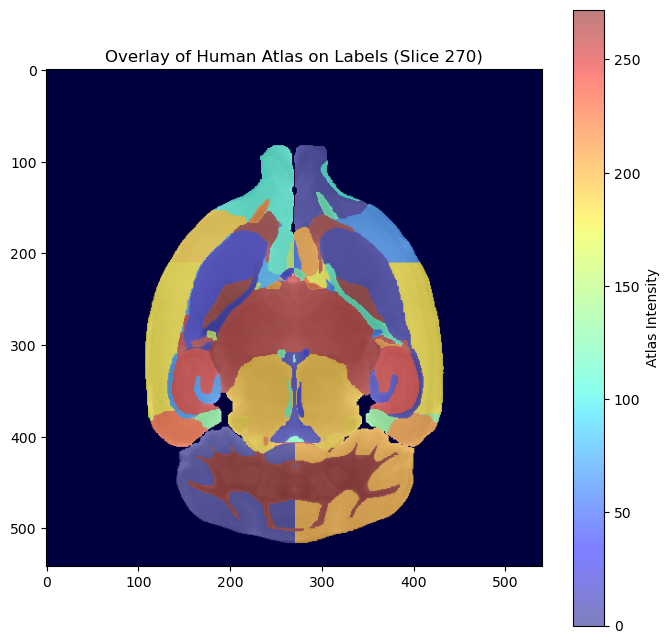

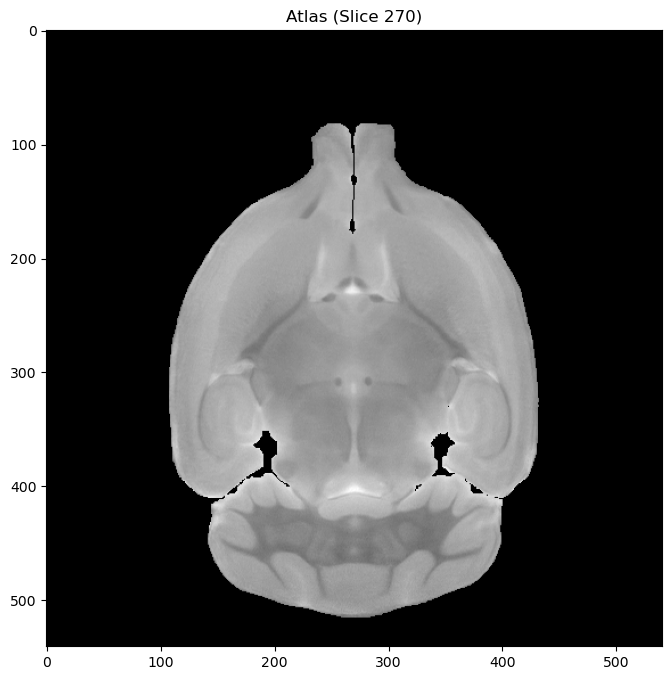

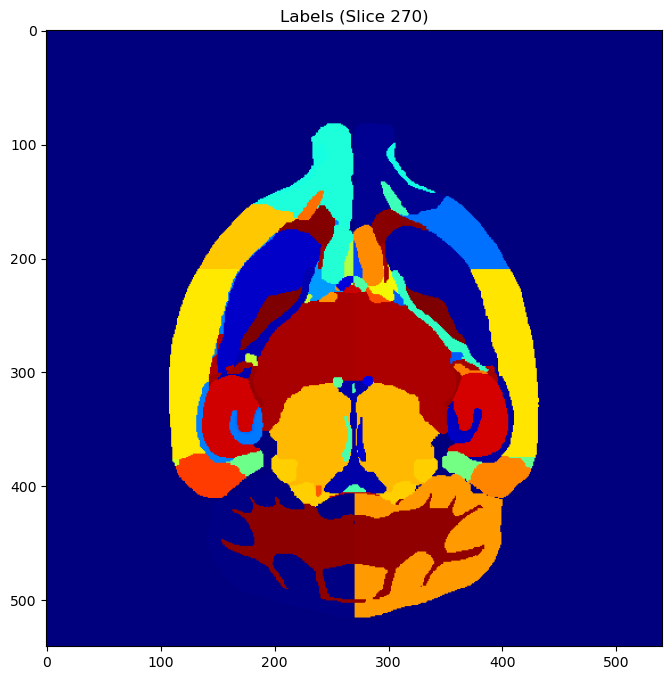

In [26]:
# plot to debug

image = sitk.ReadImage("./atlases/mouse_atlas_common_proc.nii")

overlay = sitk.ReadImage("./atlases/mouse_labels_common_proc.nii")


atlas_array = sitk.GetArrayFromImage(image)
labels_array = sitk.GetArrayFromImage(overlay)

print("atlas:", atlas_array.shape)
print("labels:", labels_array.shape)

# Select a slice index (e.g., middle slice along the axial plane)
slice_idx = atlas_array.shape[2]//2  # Middle slice

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(atlas_array[slice_idx, :, :], cmap="gray", alpha=1.0)  
plt.imshow(labels_array[slice_idx, :, :], cmap="jet", alpha=0.5) # overlay

plt.title(f"Overlay of Human Atlas on Labels (Slice {slice_idx})")
plt.colorbar(label="Atlas Intensity")
plt.show()

plt.figure(figsize=(8, 8))
plt.title(f"Atlas (Slice {slice_idx})")
plt.imshow(atlas_array[slice_idx, :, :], cmap="gray", alpha=1.0)  
plt.show()

plt.figure(figsize=(8, 8))
plt.title(f"Labels (Slice {slice_idx})")
plt.imshow(labels_array[slice_idx, :, :], cmap="jet", alpha=1.0)  